# Analysis of a DNS-based DDoS attack

## Data Preparation

First, we need to convert the pcap file into a text file that we can use as input to Pandas for later analysis. To convert, we use `tshark`. We can install `tshark` as follows:

> `sudo apt-get install tshark`

Note that the conversation process is time-consuming. In addition, there may be error messages such as "Error Traversing Database for ipnum...". We can simply ignore these message as it will not affect the output. 

In [1]:
# This operation is extremely timing consuming. At least you only need to do it at ONCE!
!tshark -n -r 'ipstresser_booter.pcap' -E separator=\;  -E header=y -T fields \
-e frame.time_epoch \
-e ip.proto \
-e ip.src \
-e ip.dst \
-e udp.srcport \
-e udp.dstport \
-e tcp.srcport \
-e tcp.dstport \
-e frame.len \
-e dns.qry.type \
-e dns.qry.name \
-e dns.resp.name > pcap.txt

Import the libraries that we need to prepare and analyse the data.

In [2]:
import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.html
import seaborn as sns

plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

#Magic line: to show the plots inline in the Jupyter Notebook
%matplotlib inline 

#import warnings
#warnings.filterwarnings('ignore') #To avoid showing annoying warns

Import the converted file into Pandas 

In [3]:
df = pd.read_csv('pcap.txt', error_bad_lines=False, sep=';')

In [4]:
df.head()

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name
0,1.419263e+09,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,62,NaN,NaN,NaN
1,1.419263e+09,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,62,NaN,NaN,NaN
2,1.419263e+09,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,103,1.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
3,1.419263e+09,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,103,28.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
4,1.419263e+09,17,172.31.0.2,172.31.28.132,53.0,51139.0,NaN,NaN,164,28.0,ip-172-31-28-132.us-west-2.compute.internal,us-west-2.compute.internal


Convert column values

In [5]:
def timestamp2datetime(series):
    return  pd.to_datetime(series,unit='s',errors='coerce')

def bytes2bits(series):
    try:
        return  series*8
    except AttributeError:
        return series

df['frame.time_epoch']=timestamp2datetime(df['frame.time_epoch'])
df['frame.len']=bytes2bits(df['frame.len'])

In [72]:
df.head()

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name,frame.len.bits
0,2014-12-22 15:38:42.525945000,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN,496
1,2014-12-22 15:38:42.525981999,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,496,NaN,NaN,NaN,496
2,2014-12-22 15:38:42.648396000,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,1.0,ip-172-31-28-132.us-west-2.compute.internal,NaN,824
3,2014-12-22 15:38:42.648422000,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,824,28.0,ip-172-31-28-132.us-west-2.compute.internal,NaN,824
4,2014-12-22 15:38:42.648629000,17,172.31.0.2,172.31.28.132,53.0,51139.0,NaN,NaN,1312,28.0,ip-172-31-28-132.us-west-2.compute.internal,us-west-2.compute.internal,1312


## Data Analysis

### 1. How many records are in the entire trace?

In [8]:
df.shape

(185576, 13)

### 2. What is the duration of the trace ?

In [15]:
first_timestamp = df['frame.time_epoch'][0]
last_timestamp = df['frame.time_epoch'][df.shape[0]-1]
last_timestamp - first_timestamp

Timedelta('0 days 00:04:58.455321')

### 3. Which is the main target IP involved in the attack?

In [50]:
df['ip.dst'].value_counts().index[0]

'172.31.28.132'

### 4. What is the \16 subnet of the main target IP involved in the attack?

In [55]:
main_target_ip = df['ip.dst'].value_counts().index[0]
octets = main_target_ip.split('.')
'{}.{}.0.0'.format(octets[0], octets[1])

'172.31.0.0'

### 5. Which is the IP protocols most used in the trace?

In [28]:
df['ip.proto'].value_counts()

17      182879
1,17      2655
1            6
1,6          5
6            5
Name: ip.proto, dtype: int64

According to [Wikipedia](https://en.wikipedia.org/wiki/List_of_IP_protocol_numbers), the above protocol numbers correspond to:

- 17: UDP
-  1: ICMP
-  6: TCP

### 6. Which is/are the main source port(s)?

In [35]:
df['udp.srcport'].value_counts().head()

53.0       184348
137.0           6
34494.0         4
37716.0         4
33639.0         4
Name: udp.srcport, dtype: int64

### 7. Which is/are the main destination port(s)?

In [41]:
df['udp.dstport'].value_counts().head()

80.0       183172
53.0         1176
137.0           6
33639.0         4
35472.0         4
Name: udp.dstport, dtype: int64

### 8. Which DNS query was not used in the attack?

In [44]:
df['dns.qry.name'].value_counts()

bls.gov                                        36550
nlhosting.nl                                   26930
sandia.gov                                     23677
isc.org                                        18898
verisign.com                                   15687
1x1.cz                                         15461
sema.cz                                        13945
ietf.org                                       13575
irs.gov                                        13028
doc.gov                                         5421
ip-172-31-28-132.us-west-2.compute.internal     2352
Name: dns.qry.name, dtype: int64

### 9. How much was the data rate peak of the attack [Mbits/second]?

<img src="question-9.png" style="width:500px;" />

In [135]:
def get_attack_records(type = 0):
    top1_target_ip = df['ip.dst'].value_counts().index[0]
    target_ip_octets = top1_target_ip.split('.')
    target_network = '{}.{}'.format(target_ip_octets[0], target_ip_octets[1])
    top1_target_ip_proto = df['ip.proto'].value_counts().index[0]
    top_dnsquery=df['dns.qry.name'].value_counts().index[0]
    udp_srcip_dstip_top1=df[df['ip.dst']==top1_target_ip]['ip.src'].value_counts()
    udp_srcport_top1=df[df['ip.dst']==top1_target_ip]['udp.srcport'].value_counts()
    udp_dstport_top1=df[df['ip.dst']==top1_target_ip]['udp.dstport'].value_counts()

    if type == 1:
        # MANUAL SELECTION: Considering the attack from ONE to ONE port!!!
        attack_records=df[df['ip.dst']==top1_target_ip]\
                        [df['ip.src'].str.contains(target_network)==False]\
                        [df['ip.proto']==top1_target_ip_proto]\
                        [df['udp.srcport']==udp_srcport_top1.index[0]]\
                        [df['udp.dstport']==udp_dstport_top1.index[0]]
    elif type == 2:
        # MANUAL SELECTION: Considering the attack from ONE to MANY ports!!!
        attack_records=df[df['ip.dst']==top1_target_ip]\
                         [df['ip.src'].str.contains(target_network)==False]\
                         [df['ip.proto']==top1_target_ip_proto]\
                         [df['udp.srcport']==udp_srcport_top1.index[0]]\
                         [df['dns.qry.name'].str.contains(top_dnsquery)==True]
    elif type == 3:
        # MANUAL SELECTION: Considering the attack from MANY to ONE port!!!
        attack_records=df[df['ip.dst']==top1_target_ip]\
                        [df['ip.src'].str.contains(target_network)==False]\
                        [df['ip.proto']==top1_target_ip_proto]\
                        [df['udp.dstport']==udp_dstport_top1.index[0]]\
                        [df['dns.qry.name'].str.contains(top_dnsquery)==True]
    elif type == 4:
        # MANUAL SELECTION: Considering the attack from MANY to MANY portS!!!
        attack_records=df[df['ip.dst']==top1_target_ip]\
                        [df['ip.src'].str.contains(target_network)==False]\
                        [df['ip.proto']==top1_target_ip_proto]\
                        [df['udp.srcport']==udp_srcport_top1.index[0]]\
                        [df['udp.dstport']==udp_dstport_top1.index[0]]\
                        [df['dns.qry.name'].str.contains(top_dnsquery)==True]
    else:
        attack_records = []
    return attack_records


def plot_attack(attack_records):
    overall_bps=df.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
    attack_bps=attack_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
    attack_bps_median=attack_bps.median()
    attack_bps_peak=max(attack_bps['sum'])
    
    remaining_records=df[~df.isin(attack_records)]
    remaining_bps=remaining_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
    fig = plt.figure(figsize=(12,4))

    ax = plt.subplot2grid((1,1), (0,0))

    attack_bps.plot(ax=ax, lw=1)
    ax.fill_between(attack_bps.index, 0, attack_bps['sum'],color='r')

    ax.annotate(str(attack_bps_peak/10e6)+' Mb/s [peak]', (str(attack_bps[attack_bps['sum'] == attack_bps_peak].index.values[0]), attack_bps_peak),
                 xytext=(0, 0), textcoords='offset points')
    ax.annotate(str(attack_bps_median[0]/10e6)+' Mb/s [median]', (str(attack_bps.index.values[0]), attack_bps_median),
                 xytext=(90, 0), textcoords='offset points')

    remaining_bps.plot(ax=ax)

    ax.legend(['Attacks records','Remaining records'])
    ax.set_ylabel("Data [bit]")
    ax.set_xlabel("Time [second]")
    
    
    print('Total Records: {} records (100%).'.format(len(df)))
    print('Attack Records: {} records ({}%).'.format(len(attack_records), np.ceil(len(attack_records)*100/len(df))))

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Total Records: 185576 records (100%).
Attack Records: 180522 records (98.0%).


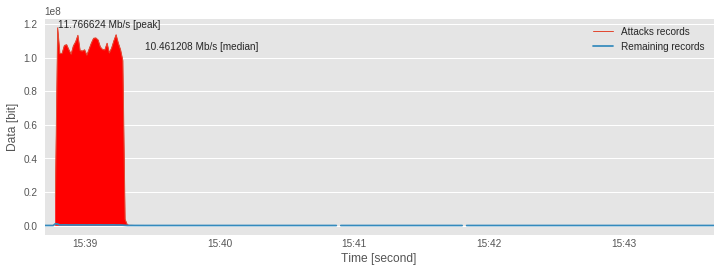

In [136]:
plot_attack(get_attack_records(1))

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Total Records: 185576 records (100%).
Attack Records: 36193 records (20.0%).


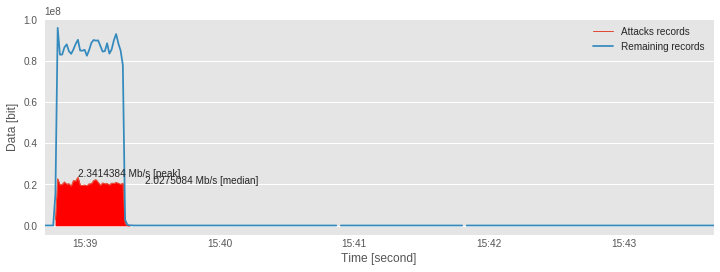

In [137]:
plot_attack(get_attack_records(2))

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Total Records: 185576 records (100%).
Attack Records: 36193 records (20.0%).


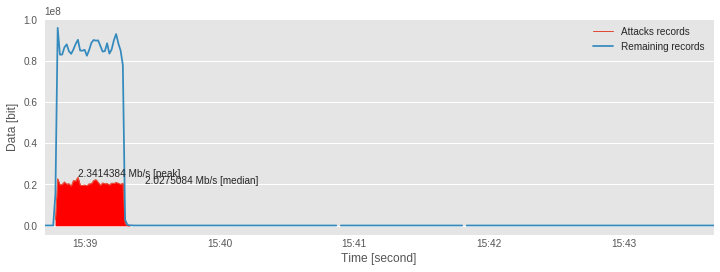

In [138]:
plot_attack(get_attack_records(3))

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Total Records: 185576 records (100%).
Attack Records: 36193 records (20.0%).


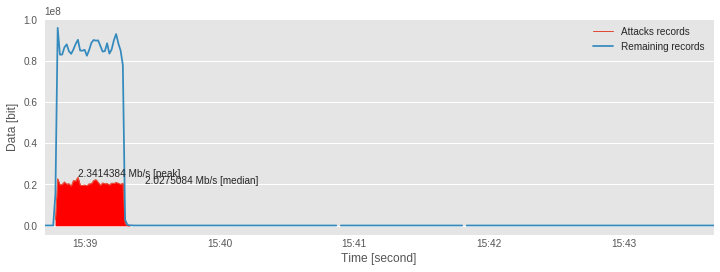

In [139]:
plot_attack(get_attack_records(4))

### 10. What was the attack duration?

In [147]:
def attack_duration(attack_records):
    print('Attack duration: {}'.format(max(attack_records['frame.time_epoch'])-min(attack_records['frame.time_epoch'])))

attack_duration(get_attack_records(1))
attack_duration(get_attack_records(2))
attack_duration(get_attack_records(3))
attack_duration(get_attack_records(4))

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Attack duration: 0 days 00:00:45.173037


/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Attack duration: 0 days 00:00:33.000275


/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Attack duration: 0 days 00:00:33.000275


/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Attack duration: 0 days 00:00:33.000275


### 11. How many (only) attack records are in total?

In [149]:
get_attack_records(1).shape[0]

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


180522

### 12. How many (source) IPs were involved in the attack?

In [150]:
len(get_attack_records(1)['ip.src'].unique())

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


79

### 13. Which IP address is NOT in the list of the top 5 IP addresses that sent more PACKETS?

In [153]:
get_attack_records(1)['ip.src'].value_counts().head(5)

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37.123.96.179    16590
61.93.9.158      12103
121.32.89.198     9435
89.228.8.86       7170
189.90.244.42     6713
Name: ip.src, dtype: int64

### 14. Which IP address is NOT in the list of the top 5 IP addresses that sent more BYTES?

In [156]:
attack_records = get_attack_records(1)

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [166]:
top5_src_ips = attack_records.groupby('ip.src').agg({'frame.len': np.sum}).sort_values('frame.len', ascending=False).head(5)
top5_src_ips

,frame.len
ip.src,
37.123.96.179,432970760
61.93.9.158,293920112
121.32.89.198,173137256
189.90.244.42,161686336
60.250.159.61,133692344


### 15. In which country the IP address that sent more traffic (packets and data) is located?

In [168]:
attack_records = get_attack_records(1)
top5_src_ips = attack_records.groupby('ip.src').agg({'frame.len': np.sum}).sort_values('frame.len', ascending=False).head(5)
top_ip = top5_src_ips.index[0]
top_ip

/home/omar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


'37.123.96.179'

In [170]:
import subprocess
p = subprocess.Popen(['whois', '-h', 'whois.cymru.com','\"', '-v',top_ip,'\"' ], stdout=subprocess.PIPE)
print(p.communicate()[0])

b'Warning: RIPE flags used with a traditional server.\nAS      | IP               | BGP Prefix          | CC | Registry | Allocated  | AS Name\n57844   | 37.123.96.179    | 37.123.96.0/24      | TR | ripencc  | 2012-02-15 | SALAY, TR\n'
